In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_dir = "/content/drive/MyDrive/"
base_dir = root_dir + 'flower_data/'

train_dir = base_dir + 'train'
valid_dir = base_dir + 'valid'
test_dir = base_dir + 'test'

In [3]:

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
import time
from PIL import Image
import matplotlib



# **Import Dataset**


In [ ]:

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info

test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete3OB5EK/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete3OB5EK/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete3OB5EK/oxford_flowers102-validation.tfrecord


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:

num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

for example in test_set:
  num_test_examples += 1

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))

num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes: {}'.format(num_classes))

NameError: ignored

In [ ]:
for i, example in enumerate(training_set.take(3)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

NameError: ignored

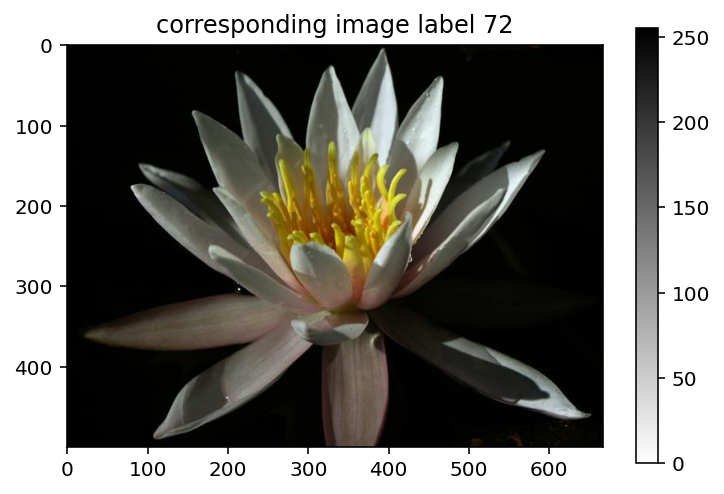

In [ ]:
for image, label in training_set.take(1):
  break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
# TODO: Load the datasets with ImageFolder
image_datasets = {}
image_datasets["train"] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets["valid"] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets["test"] = datasets.ImageFolder(test_dir, transform=test_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets["train"], batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(image_datasets["valid"], batch_size=32)
test_loader = torch.utils.data.DataLoader(image_datasets["test"], batch_size=32)

### **ALEEEEEEEEEE ho fatto un esperimento seguendo una**

### Per vedere i nomi delle categorie

In [ ]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

Pre-train + classificatore fullyconnected neural net

In [ ]:
# Load in a pre-trained model, DenseNet
model = models.densenet121(pretrained=True)
# model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
for param in model.parameters():
    param.requires_grad = False # Freeze parameters so we don't backprop through them

classifier = nn.Sequential(OrderedDict([
                          ('dropout1', nn.Dropout(0.1)),
                          ('fc1', nn.Linear(1024, 512)), # 1024 must match
                          ('relu1', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.1)),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [7]:
# Measure the validation loss and accuracy
def validation(model, dataloader, criterion):
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in iter(dataloader):
            
           # images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            
            output = model.forward(images)
            loss += criterion(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

In [ ]:
# Criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 5
print_every = 40
steps = 0
running_loss = 0
train_accuracy = 0



for e in range(epochs):


    model.train() # Dropout is turned on for training

    for images, labels in iter(train_loader):
    
     # images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU

      steps += 1
      optimizer.zero_grad()
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

            # get the class probabilities from log-softmax
      ps = torch.exp(output) 
      equality = (labels.data == ps.max(dim=1)[1])
      train_accuracy += equality.type(torch.FloatTensor).mean()

      if steps % print_every == 0:
      
        model.eval() # Make sure network is in eval mode for inference

        with torch.no_grad():


          valid_loss, valid_accuracy = validation(model, valid_loader, criterion)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Training Accuracy: {:.3f}".format(train_accuracy/print_every),
                      "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)),
                      "Validation Accuracy: {:.3f}".format(valid_accuracy/len(valid_loader)))

        running_loss = 0
        train_accuracy = 0
        model.train() # Make sure training is back on
                
print("\nTraining completed!")

Epoch: 1/5..  Training Loss: 4.039..  Training Accuracy: 0.152 Validation Loss: 3.150..  Validation Accuracy: 0.341
Epoch: 1/5..  Training Loss: 2.720..  Training Accuracy: 0.428 Validation Loss: 1.830..  Validation Accuracy: 0.607
Epoch: 2/5..  Training Loss: 1.749..  Training Accuracy: 0.616 Validation Loss: 1.136..  Validation Accuracy: 0.774
Epoch: 2/5..  Training Loss: 1.387..  Training Accuracy: 0.679 Validation Loss: 0.832..  Validation Accuracy: 0.801
Epoch: 2/5..  Training Loss: 1.118..  Training Accuracy: 0.732 Validation Loss: 0.640..  Validation Accuracy: 0.866
Epoch: 3/5..  Training Loss: 0.930..  Training Accuracy: 0.774 Validation Loss: 0.548..  Validation Accuracy: 0.869
Epoch: 3/5..  Training Loss: 0.850..  Training Accuracy: 0.789 Validation Loss: 0.549..  Validation Accuracy: 0.874
Epoch: 4/5..  Training Loss: 0.832..  Training Accuracy: 0.791 Validation Loss: 0.425..  Validation Accuracy: 0.908
Epoch: 4/5..  Training Loss: 0.721..  Training Accuracy: 0.815 Validatio

**Testing  network**

In [ ]:
# TODO: Do validation on the test set
model.eval()
with torch.no_grad():
    test_loss, test_accuracy = validation(model, test_loader, criterion)
    
print('Accuracy of the network on the test images: %d %%' % (100 * test_accuracy/len(test_loader)))

Accuracy of the network on the test images: 92 %


In [ ]:
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'input_size': 224*224*3,
              'output_size': 102,
              'model': model,
              'state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict,
              'criterion': criterion,
              'epochs': epochs,
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:

# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [ ]:

model = load_checkpoint('checkpoint.pth')
# print(model)

In [ ]:
def process_image(pil_image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    width, height = pil_image.size
    aspect_ratio = width / height
    if aspect_ratio > 1:
        pil_image = pil_image.resize((round(aspect_ratio * 256), 256))
    else:
        pil_image = pil_image.resize((256, round(256 / aspect_ratio)))
    
    # Crop out the center 224x224 portion of the image
    width, height = pil_image.size
    new_width = 224
    new_height = 224
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    pil_image = pil_image.crop((round(left), round(top), round(right), round(bottom)))
    
    # Convert color channels to 0-1
    np_image = np.array(pil_image) / 255
    
    # Normalize the image
    np_image = (np_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    
    # Reorder dimensions
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

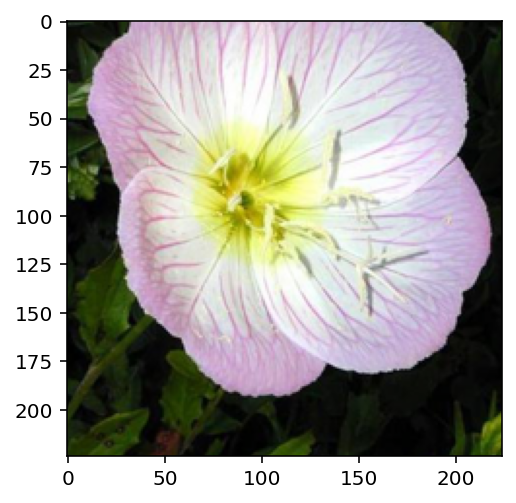

In [ ]:
pil_image = Image.open(test_dir + "/1/image_06743.jpg")
np_image = process_image(pil_image)
imshow(np_image)

In [ ]:

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    pil_image = Image.open(image_path)
    np_image = process_image(pil_image)

    model.to(device)
    model.eval()
    
    with torch.no_grad():
        images = torch.from_numpy(np_image)
        images = images.unsqueeze(0)
        images = images.type(torch.FloatTensor)
        images = images.to(device) # Move input tensors to the GPU/CPU

        output = model.forward(images)
        ps = torch.exp(output) # get the class probabilities from log-softmax

        probs, indices = torch.topk(ps, topk)
        probs = [float(prob) for prob in probs[0]]
        inv_map = {v: k for k, v in model.class_to_idx.items()}
        classes = [inv_map[int(index)] for index in indices[0]]
        
    return probs, classes

In [ ]:
image_path = test_dir + "/2/image_05107.jpg"
probs, classes = predict(image_path, model, topk=5)
print("probs: ", probs) 
print("classes: ", classes)

probs:  [0.9874382615089417, 0.005458184517920017, 0.0042629181407392025, 0.001211656490340829, 0.00043462359462864697]
classes:  ['2', '7', '69', '52', '96']


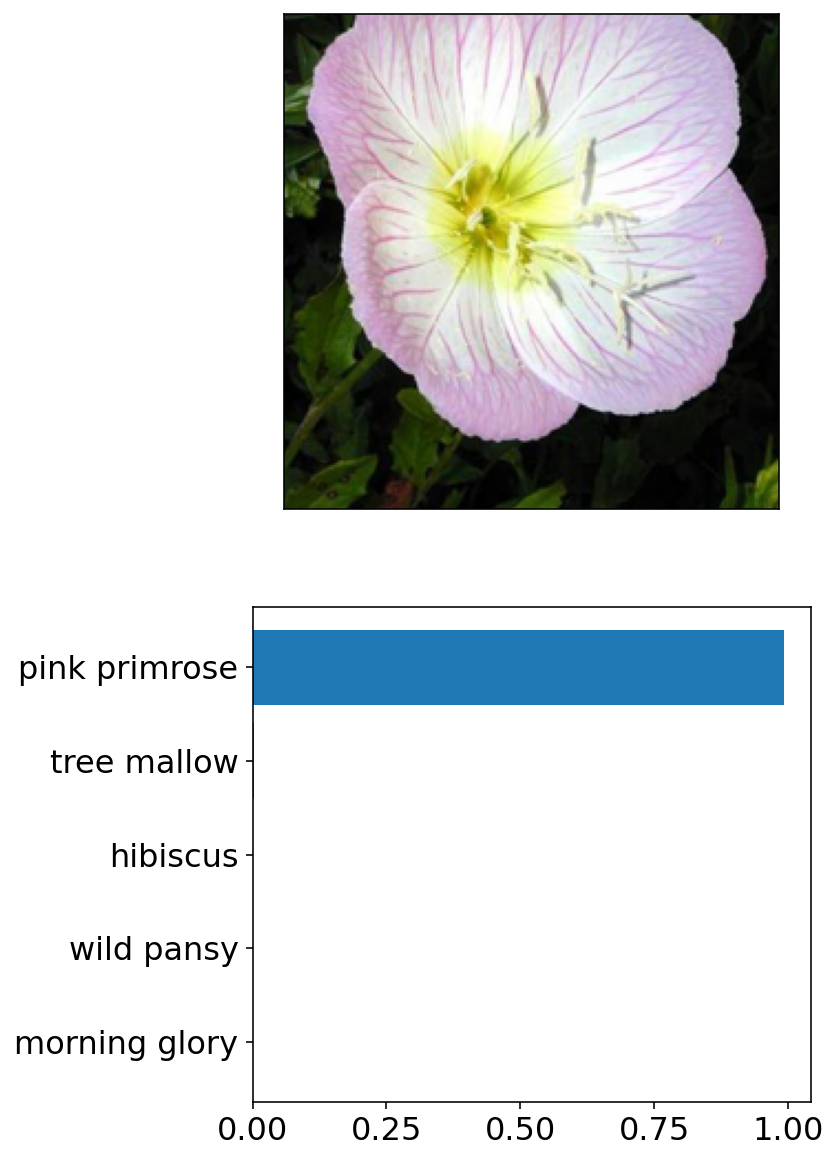

In [ ]:
# TODO: Display an image along with the top 5 classes
image_path = test_dir + "/1/image_06743.jpg"

f = plt.figure(figsize=(5,10))
matplotlib.rcParams.update({'font.size': 16})

ax = f.add_subplot(211)
pil_image = Image.open(test_dir + "/1/image_06743.jpg")
np_image = process_image(pil_image)
imshow(np_image, ax=ax)
ax.set_yticks([])
ax.set_xticks([])

plt.subplot(212)
probs, classes = predict(image_path, model, topk=5)
classes_name = [cat_to_name[class_i] for class_i in classes]
plt.barh(range(len((classes_name))), probs)
plt.yticks(range(len(classes_name)),classes_name)
plt.gca().invert_yaxis()

### Esperimento 2


In [5]:
# Load in a pre-trained model, DenseNet
vgg16_pretrained = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [8]:
for param in vgg16_pretrained.parameters():
    param.requires_grad = False # Freeze parameters so we don't backprop through them

classifier = nn.Sequential(OrderedDict([
                          ('dropout1', nn.Dropout(0.1)),
                          ('fc1', nn.Linear(1024, 512)), # 1024 must match
                          ('relu1', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.1)),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
vgg16_pretrained.classifier = classifier

In [10]:
# Criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16_pretrained.classifier.parameters(), lr=0.001)

In [12]:
epochs = 5
print_every = 40
steps = 0
running_loss = 0
train_accuracy = 0



for e in range(epochs):


    vgg16_pretrained.train() # Dropout is turned on for training

    for images, labels in iter(train_loader):
    
     # images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU

      steps += 1
      optimizer.zero_grad()
      output = vgg16_pretrained.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

            # get the class probabilities from log-softmax
      ps = torch.exp(output) 
      equality = (labels.data == ps.max(dim=1)[1])
      train_accuracy += equality.type(torch.FloatTensor).mean()

      if steps % print_every == 0:
      
        vgg16_pretrained.eval() # Make sure network is in eval mode for inference

        with torch.no_grad():


          valid_loss, valid_accuracy = validation(vgg16_pretrained, valid_loader, criterion)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Training Accuracy: {:.3f}".format(train_accuracy/print_every),
                      "Validation Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)),
                      "Validation Accuracy: {:.3f}".format(valid_accuracy/len(valid_loader)))

        running_loss = 0
        train_accuracy = 0
        vgg16_pretrained.train() # Make sure training is back on
                
print("\nTraining completed!")

Epoch: 1/5..  Training Loss: 3.996..  Training Accuracy: 0.175 Validation Loss: 3.007..  Validation Accuracy: 0.379
Epoch: 1/5..  Training Loss: 2.618..  Training Accuracy: 0.447 Validation Loss: 1.712..  Validation Accuracy: 0.586
Epoch: 2/5..  Training Loss: 1.732..  Training Accuracy: 0.609 Validation Loss: 1.030..  Validation Accuracy: 0.769
Epoch: 2/5..  Training Loss: 1.302..  Training Accuracy: 0.704 Validation Loss: 0.809..  Validation Accuracy: 0.818
Epoch: 2/5..  Training Loss: 1.082..  Training Accuracy: 0.741 Validation Loss: 0.638..  Validation Accuracy: 0.853
Epoch: 3/5..  Training Loss: 0.943..  Training Accuracy: 0.773 Validation Loss: 0.503..  Validation Accuracy: 0.871
Epoch: 3/5..  Training Loss: 0.840..  Training Accuracy: 0.792 Validation Loss: 0.496..  Validation Accuracy: 0.874
Epoch: 4/5..  Training Loss: 0.782..  Training Accuracy: 0.800 Validation Loss: 0.422..  Validation Accuracy: 0.892
Epoch: 4/5..  Training Loss: 0.653..  Training Accuracy: 0.829 Validatio

In [13]:
# TODO: Do validation on the test set
vgg16_pretrained.eval()
with torch.no_grad():
    test_loss, test_accuracy = validation(vgg16_pretrained, test_loader, criterion)
    
print('Accuracy of the network on the test images: %d %%' % (100 * test_accuracy/len(test_loader)))

Accuracy of the network on the test images: 90 %


In [14]:
vgg16_pretrained.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'input_size': 224*224*3,
              'output_size': 102,
              'model': vgg16_pretrained,
              'state_dict': vgg16_pretrained.state_dict(),
              'optimizer_state_dict': optimizer.state_dict,
              'criterion': criterion,
              'epochs': epochs,
              'class_to_idx': vgg16_pretrained.class_to_idx}

torch.save(checkpoint, 'vgg16.pth')